In [1]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for notebook
from tqdm.notebook import tqdm

# models to try
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

# data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline

# model evaluation
from sklearn.metrics import f1_score

# for loading and saving
import pickle

## Summary

This notebook will try multiple models to find the best predictive algorithm.

## Load Data and Scale

In [2]:
# load and inspect
model_data = pd.read_csv('./data/HR_data_for_model.csv', index_col=0)

# scale
for col in ['number_projects', 'average_monthly_hours', 'years_with_company']:
    model_data[col] = model_data[col] / model_data[col].max()

model_data.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,years_with_company,work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,0.285714,0.506452,0.3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,0.714286,0.845161,0.6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,1.000000,0.877419,0.4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,0.714286,0.719355,0.5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,0.285714,0.512903,0.3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


## Drop Duplicates

In [3]:
# calculate total percent duplicate rows
model_data.duplicated().sum() / len(model_data)

0.2005467031135409

*approx. 20% of the data are duplicates, <br> while in later analysis, we will assume the duplicates are different people with the same experience and thus keep it, for modeling it is not helpful and will be dropped*

In [4]:
# duplicates can skew model performance so they will be dropped for training
model_data.drop_duplicates(inplace=True)

# recount duplicates for verification 
model_data.duplicated().sum() / len(model_data)

0.0

## Train Test Split

In [5]:
# train/test data
X = model_data.drop(columns=['left'])
y = model_data['left']

In [6]:
# observe target distribution
y.value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [7]:
# data is stratified due to uneven distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

## Model Testing

First, the following models will be tested and tuned with Bayesian Hyperparameter Optimization 
- Logistic Regression
- Random Forest
- Gradient Boosting
- Support Vector



### Define Search Space

Defines each model to be tested and the range of hyperparameters to be explored.

In [8]:
# Logistic Regression Search
log_reg_search = {
    'model' : Categorical([LogisticRegression()]),
    'model__C' : Real(.001, 1000, prior='log-uniform')
}

# Random Forest Search
rnd_fst_search = {
    'model': Categorical([RandomForestClassifier()]),
    'model__n_estimators'     : Integer(10, 1000),
    'model__max_depth'        : Integer(2,  1000),
    'model__min_samples_leaf' : Integer(1, 20)  
}

# Random Forest Search
xgb_cls_search = {
    'model': Categorical([XGBClassifier()]),
    'model__n_estimators'     : Integer(10, 1000),
    'model__max_depth'        : Integer(1,  1000),
    'model__learning_rate'    : Real(.01, .5)
}

# Support Vector Search
svm_svc_search = {
    'model': Categorical([SVC()]),
    'model__C'      : Real(.001, 1000, prior='log-uniform'),
    'model__kernel' : Categorical(['linear', 'poly', 'rbf'])
}

### Perform Search

Search all given models and parameters using 3-fold cross-validation.

In [2]:
# init dummy model
search_model = Pipeline([('model', None)])

# to handle depreciated numpy call
np.int = int

# define search
bayes_model_search = BayesSearchCV(
    search_model,
    [
        (log_reg_search, 50),
        (rnd_fst_search, 500),
        (xgb_cls_search, 500),
        (svm_svc_search, 100),
    ],
    scoring='f1',
    cv=3,
)

# search
# bayes_model_search.fit(X_train, y_train)

# load search file to save time
with open('./pkl/bayes_model_search.pkl', 'rb') as file:
    bayes_model_search = pickle.load(file)

### F1 Score on Test Set for Best CV Models

Choose the best hyperparameters for each model type and get an F1 Score on the test set.

In [10]:
models = [['log_reg', LogisticRegression()],
          ['rnd_fst', RandomForestClassifier()], 
          ['xgb_cls', XGBClassifier()],
          ['svm_svc', SVC()]]

test_f1_scores = {}
indicies  = np.arange(1150)

for model_name, model in models:
    select   = [type(param_model) == type(model) for param_model in bayes_model_search.cv_results_['param_model']]
    idx_best = bayes_model_search.cv_results_['mean_test_score'][select].argmax()
    idx_best = indicies[select][idx_best]

    search_model.set_params(**bayes_model_search.cv_results_['params'][idx_best])
    search_model.fit(X_train, y_train)

    y_pred = search_model.predict(X_test)
    
    test_f1_scores[model_name] = f1_score(y_test, y_pred)

### Neural Network Search

A simple mlp will be hyperparameter tuned at various depths and widths.

*a custom implementation of `tf.keras.metrics.F1Score` due to a stange error with using `convert_to_tensor` instead of `cast`*

In [11]:
class F1Score(tf.keras.metrics.F1Score):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=self.dtype) # changed to cast
        y_pred = tf.cast(y_pred, dtype=self.dtype) # changed to cast
        if not self.built:
            self.build(y_true.shape, y_pred.shape)

        if self.threshold is None:
            threshold = tf.reduce_max(y_pred, axis=-1, keepdims=True)
            # make sure [0, 0, 0] doesn't become [1, 1, 1]
            # Use abs(x) > eps, instead of x != 0 to check for zero
            y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-9)
        else:
            y_pred = y_pred > self.threshold
        y_pred = tf.cast(y_pred, dtype=self.dtype)

        def _weighted_sum(val, sample_weight):
            if sample_weight is not None:
                val = tf.math.multiply(val, tf.expand_dims(sample_weight, 1))
            return tf.reduce_sum(val, axis=self.axis)

        self.true_positives.assign_add(
            _weighted_sum(y_pred * y_true, sample_weight)
        )
        self.false_positives.assign_add(
            _weighted_sum(y_pred * (1 - y_true), sample_weight)
        )
        self.false_negatives.assign_add(
            _weighted_sum((1 - y_pred) * y_true, sample_weight)
        )
        self.intermediate_weights.assign_add(
            _weighted_sum(y_true, sample_weight)
        ) 

### Neural Network Hyperparameter Tuning

This is a grid search over the following values:
- hidden layers: {3, 4, 5, 6, 7}
- nodes per layers: {128, 256, 512, 1024}

In [4]:
layers = [range(3)] * 4 + [range(4)] * 4 + [range(5)] * 4 + [range(6)] * 4 + [range(7)] * 4
nodes  = [128, 256, 512, 1024] * 5

mlp_results = []

for layers, nodes in tqdm(zip(layers, nodes), total=len(layers)):
    continue # to save time, results loaded below

    mlp = tf.keras.Sequential([
        tf.keras.layers.Input([18]),
        *[tf.keras.layers.Dense(nodes, 'relu') for _ in layers],
        tf.keras.layers.Dense(1, 'sigmoid')
    ])
    
    mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score(threshold=0.5, dtype=tf.float32)])
    history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), verbose=0)

    mlp_results.append([f'{layers}_{nodes}', np.array(history.history['val_f1_score']).max()])

# results pre-calculated to save time
with open('./pkl/mlp_results.pkl', 'rb') as file:
    mlp_results = pickle.load(file)

test_f1_scores['mlp_cls'] = pd.DataFrame(mlp_results)[1].max()

### Display Results

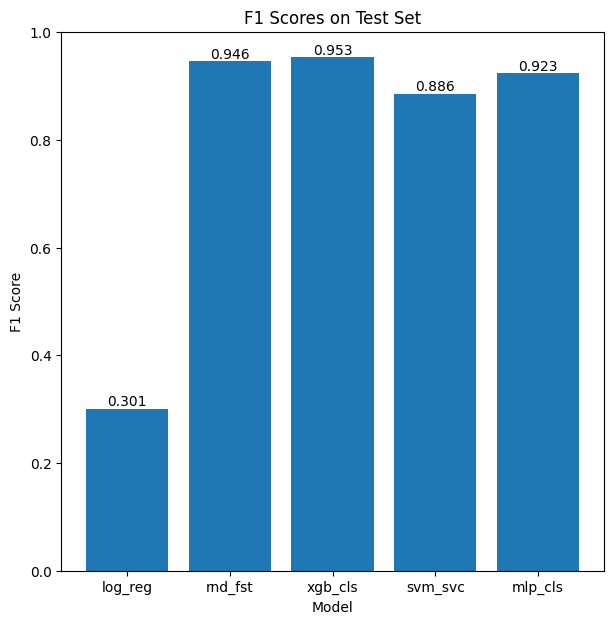

In [13]:
plt.figure(figsize=(7, 7))

plt.bar(test_f1_scores.keys(), test_f1_scores.values())

for x, y, s in zip(range(5), test_f1_scores.values(), test_f1_scores.values()):
    s = round(s, 3)
    plt.text(x, y, s, va='bottom', ha='center')

plt.title('F1 Scores on Test Set')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.show()

### Best Model - XGBoost Classifier

Though RandomForestClassifier performed the best on the 3-fold cross validation, XGBClassifier had the highest test set f1 score.

In [14]:
# show params of best XGBoost Classifier

select   = [type(param_model) == type(XGBClassifier()) for param_model in bayes_model_search.cv_results_['param_model']]
idx_best = bayes_model_search.cv_results_['mean_test_score'][select].argmax()
idx_best = indicies[select][idx_best]
bayes_model_search.cv_results_['params'][idx_best]

OrderedDict([('model',
              XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None, feature_types=None,
                            gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=0.01, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=7, max_leaves=None,
                            min_child_weight=None, missing=nan, monotone_constraints=None,
                            n_estimators=951, n_jobs=None, num_parallel_tree=None,
                            predictor=None, random_state=None, ...)),
             ('model__learning_rate', 0.01),
             ('model__max_d

### Re-Train Best Model

XGBoost is a scale-invariant model.  To ease future model interpretation, it will be re-trained on un-scaled data.

In [15]:
# reload unscaled data
model_data = pd.read_csv('./data/HR_data_for_model.csv', index_col=0)

model_data.drop_duplicates(inplace=True)

# seperate inputs and targets
X = model_data.drop(columns=['left'])
y = model_data['left']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [16]:
# init XGBoost with best optimized hyperparameters

model_params = {
    'learning_rate' : 0.01,
    'max_depth'     : 7,
    'n_estimators'  : 951
}
model = XGBClassifier(**model_params)

# train on unscaled data
model.fit(X_train, y_train)

# test on unscaled data
y_pred = model.predict(X_test)

# print results
print('XGBoost Unscaled Data F1 Score:', round(f1_score(y_test, y_pred), 3))

XGBoost Unscaled Data F1 Score: 0.953


In [27]:
### save model

# commented out for no-overwrite
# with open('./pkl/xgb_best.pkl', 'wb') as file:
#     pickle.dump(model, file)

### Next Step: [Analysis](3_Data_Analysis.ipynb)